# Discrete Expression Recognition with Face Images (CK+ Dataset)
This notebook implements facial expression recognition using VGG16 with an 80/20 train-test split, and 5-fold cross-validation on the training portion for robust evaluation.

# Step 1: Mount Google Drive

In [1]:
# Mount Google Drive to access CK+ dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 2: Import Required Libraries

In [2]:
# ✅ Import all required libraries
import os, cv2, time, warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call `super().__init__.*")

# Step 3: Configuration


In [3]:
# Configuration variables
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
FOLDS = 5
SEED = 42
# Replace with the actual path inside your Google Drive
DATASET_PATH = '/content/drive/MyDrive/CK+48/CK+48'

# Step 4: Load and Preprocess Dataset

In [4]:
# Load and preprocess the CK+ dataset
def load_ckplus_data(dataset_path):
    X, y = [], []
    labels = sorted(os.listdir(dataset_path))
    label_map = {label: i for i, label in enumerate(labels)}
    for label in labels:
        path = os.path.join(dataset_path, label)
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(label_map[label])
    return np.array(X), np.array(y), label_map

In [5]:
# 😃 Emotion label dictionary for class index to name mapping
emotion_labels = {
    0: 'Angry',
    1: 'Contempt',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happy',
    5: 'Sadness',
    6: 'Surprise'
}

# Step 5: Normalize and Prepare Data

In [6]:
# Load and normalize data (80% train, 20% test)
X, y, label_map = load_ckplus_data(DATASET_PATH)
print(f"Loaded {len(X)} images from {len(label_map)} classes.")
X = X.astype('float32') / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
class_weights = {i: max(Counter(y_train).values()) / v for i, v in Counter(y_train).items()}

Loaded 981 images from 7 classes.


# Step 6: Define VGG16 Model for Transfer Learning

In [7]:
# ✅ Optimized VGG16 model: unfreeze last 4 layers for fine-tuning
def build_model(num_classes):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='keras_tensor')
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    for layer in base.layers[:-4]:
        layer.trainable = False
    for layer in base.layers[-4:]:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 7: Data Augmentation Setup

In [8]:
# 🔁 Stronger data augmentation to boost generalization
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Step 8: Train with K-Fold Cross-Validation

In [9]:
# Train the model with early stopping and adaptive learning rate.
# K-Fold training and evaluation without multiprocessing args
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold = 1
for train_idx, val_idx in kfold.split(X_train, y_train):
    print(f'\n🔁 Fold {fold} started')
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train_cat[train_idx], y_train_cat[val_idx]

    model = build_model(num_classes=len(label_map))
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5),
        ModelCheckpoint('final_facial_expression_model.keras', save_best_only=True)
    ]
    history = model.fit(
        datagen.flow(X_tr, y_tr, batch_size=BATCH_SIZE),
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks
    )
    fold += 1


🔁 Fold 1 started
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1055 - loss: 3.8306 - val_accuracy: 0.0892 - val_loss: 1.9944 - learning_rate: 1.0000e-05
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - accuracy: 0.1108 - loss: 3.6965 - val_accuracy: 0.4968 - val_loss: 1.8475 - learning_rate: 1.0000e-05
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 468ms/step - accuracy: 0.1869 - loss: 3.4512 - val_accuracy: 0.4650 - val_loss: 1.7743 - learning_rate: 1.0000e-05
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - accuracy: 0.2022 - loss: 3.5954 - val_accuracy: 0.4395 - val_loss: 1.7456 - learning_rate: 1.0000e-05
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 507ms/step - accuracy: 0.2314 - loss: 3.4411 - val_accuracy: 0.5096 - val_loss: 1.6382 - learning_rate: 1.0000e-05
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 441ms/step - accuracy: 0.3117 - loss: 3.2206 - val_accuracy: 0.5478 - val_loss: 1.5444 - learning_rate: 1.0000e-05
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 489ms/step - accuracy

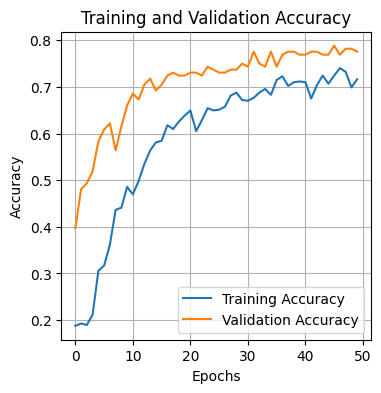

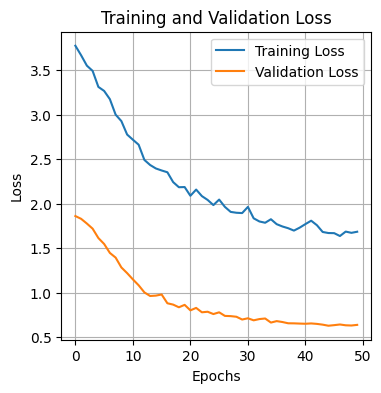

In [12]:

import matplotlib.pyplot as plt

# Plotting Training vs Validation Accuracy
plt.figure(figsize=(4, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training vs Validation Loss
plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 770ms/step

📊 Final Test Set Evaluation:
              precision    recall  f1-score   support

       anger       0.75      0.33      0.46        27
    contempt       0.56      0.45      0.50        11
     disgust       0.96      0.74      0.84        35
        fear       0.42      0.53      0.47        15
       happy       0.83      0.95      0.89        42
     sadness       0.58      0.88      0.70        17
    surprise       0.88      0.98      0.92        50

    accuracy                           0.77       197
   macro avg       0.71      0.70      0.68       197
weighted avg       0.79      0.77      0.76       197



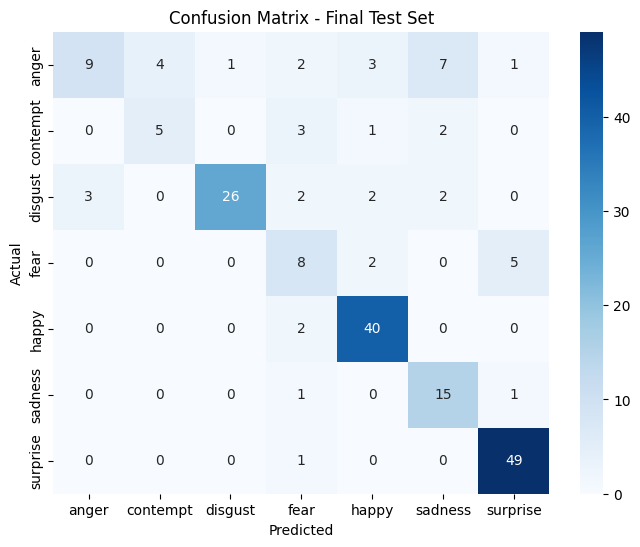

In [11]:
# Evaluate the final model on the 20% hold-out test set.
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\n📊 Final Test Set Evaluation:")
print(classification_report(y_true, y_pred_classes, target_names=label_map.keys()))
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix - Final Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()